In [136]:
using POMDPs # for MDP type
using DiscreteValueIteration
using POMDPPolicies
using POMDPModelTools #for sparse cat 
using Parameters
using Random
using Plots; default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style
using QuickPOMDPs
using Distributions 
#using PlotlyJS
using LinearAlgebra
using POMDPSimulators

In [2]:
Random.seed!(0xC0FFEE)

MersenneTwister(12648430)

**States**

In [3]:
# A state s in the evacuation problem is a discrete set of 4 values: 
# chairs remaining, time remaining, family size, and visa status
struct State
    c::Int # chairs remaining 
    t::Int # time remaining 
    f::Int # family size 
    v::Int # visa status 
end 

**Environment Parameters**

In [4]:
# assume families normally distributed as integers around average family size in afghanistan of 8. 
# Truncated to include 1 or greater and rounded to be integers 
@with_kw struct EvacuationParameters
    #family_sizes::Vector{Int} =  [trunc(Int, x) for x in rand(TruncatedNormal(3, 1, 1, Inf), 10)] 
    # or [1, 2, 3, 4, 5, 6, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9, 10, 10, 11, 12]  ?? 
    family_sizes::Vector{Int} = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # set with no repeats 
    # p_family_sizes::Vector{Float}
    # family size w/ probabilities !! 
    visa_status::Vector{Int} = [-20, -4, 0, 1, 2, 3, 4, 10] #TODO: map to various status 
    capacity::Int = 150
    time::Int = 60
    size::Tuple{Int, Int} = (length(visa_status), length(family_sizes)) # size of grid 
    p_transition::Real = 0.8 # don't we always transition into this since time moves forward? I'm confused... 
    null_state::State = State(-1, -1, -1 ,-1) # is there someway to do this???
end


EvacuationParameters

In [5]:
params = EvacuationParameters(); 

In [6]:
@show number_states = params.capacity * params.time * size(params.family_sizes)[1] * size(params.visa_status)[1]

number_states = params.capacity * params.time * (size(params.family_sizes))[1] * (size(params.visa_status))[1] = 810000


810000

In [7]:
# The state space S for the evacuation problem is the set of all combinations 
𝒮 = []

for c in 0:params.capacity # capacity ends at 0 
    for t in 0:params.time # time ends at 0 
        for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
            for v in params.visa_status # actual visa statuses 
                new = State(c, t, f, v) 
                𝒮 = [𝒮; new]
            end
        end        
    end
end

𝒮 = [𝒮; params.null_state]




828991-element Vector{Any}:
 State(0, 0, 1, -4)
 State(0, 0, 1, -3)
 State(0, 0, 1, -2)
 State(0, 0, 1, -1)
 State(0, 0, 1, 0)
 State(0, 0, 1, 1)
 State(0, 0, 1, 2)
 State(0, 0, 1, 3)
 State(0, 0, 1, 4)
 State(0, 0, 2, -4)
 State(0, 0, 2, -3)
 State(0, 0, 2, -2)
 State(0, 0, 2, -1)
 ⋮
 State(150, 60, 9, 3)
 State(150, 60, 9, 4)
 State(150, 60, 10, -4)
 State(150, 60, 10, -3)
 State(150, 60, 10, -2)
 State(150, 60, 10, -1)
 State(150, 60, 10, 0)
 State(150, 60, 10, 1)
 State(150, 60, 10, 2)
 State(150, 60, 10, 3)
 State(150, 60, 10, 4)
 State(-1, -1, -1, -1)

In [8]:
@show 𝒮

𝒮 = Any[State(0, 0, 1, -4), State(0, 0, 1, -3), State(0, 0, 1, -2), State(0, 0, 1, -1), State(0, 0, 1, 0), State(0, 0, 1, 1), State(0, 0, 1, 2), State(0, 0, 1, 3), State(0, 0, 1, 4), State(0, 0, 2, -4), State(0, 0, 2, -3), State(0, 0, 2, -2), State(0, 0, 2, -1), State(0, 0, 2, 0), State(0, 0, 2, 1), State(0, 0, 2, 2), State(0, 0, 2, 3), State(0, 0, 2, 4), State(0, 0, 3, -4), State(0, 0, 3, -3), State(0, 0, 3, -2), State(0, 0, 3, -1), State(0, 0, 3, 0), State(0, 0, 3, 1), State(0, 0, 3, 2), State(0, 0, 3, 3), State(0, 0, 3, 4), State(0, 0, 4, -4), State(0, 0, 4, -3), State(0, 0, 4, -2), State(0, 0, 4, -1), State(0, 0, 4, 0), State(0, 0, 4, 1), State(0, 0, 4, 2), State(0, 0, 4, 3), State(0, 0, 4, 4), State(0, 0, 5, -4), State(0, 0, 5, -3), State(0, 0, 5, -2), State(0, 0, 5, -1), State(0, 0, 5, 0), State(0, 0, 5, 1), State(0, 0, 5, 2), State(0, 0, 5, 3), State(0, 0, 5, 4), State(0, 0, 6, -4), State(0, 0, 6, -3), State(0, 0, 6, -2), State(0, 0, 6, -1), State(0, 0, 6, 0), State(0, 0, 6, 1),

-2), State(0, 35, 10, -1), State(0, 35, 10, 0), State(0, 35, 10, 1), State(0, 35, 10, 2), State(0, 35, 10, 3), State(0, 35, 10, 4), State(0, 36, 1, -4), State(0, 36, 1, -3), State(0, 36, 1, -2), State(0, 36, 1, -1), State(0, 36, 1, 0), State(0, 36, 1, 1), State(0, 36, 1, 2), State(0, 36, 1, 3), State(0, 36, 1, 4), State(0, 36, 2, -4), State(0, 36, 2, -3), State(0, 36, 2, -2), State(0, 36, 2, -1), State(0, 36, 2, 0), State(0, 36, 2, 1), State(0, 36, 2, 2), State(0, 36, 2, 3), State(0, 36, 2, 4), State(0, 36, 3, -4), State(0, 36, 3, -3), State(0, 36, 3, -2), State(0, 36, 3, -1), State(0, 36, 3, 0), State(0, 36, 3, 1), State(0, 36, 3, 2), State(0, 36, 3, 3), State(0, 36, 3, 4), State(0, 36, 4, -4), State(0, 36, 4, -3), State(0, 36, 4, -2), State(0, 36, 4, -1), State(0, 36, 4, 0), State(0, 36, 4, 1), State(0, 36, 4, 2), State(0, 36, 4, 3), State(0, 36, 4, 4), State(0, 36, 5, -4), State(0, 36, 5, -3), State(0, 36, 5, -2), State(0, 36, 5, -1), State(0, 36, 5, 0), State(0, 36, 5, 1), State(0,

9, 1), State(1, 10, 9, 2), State(1, 10, 9, 3), State(1, 10, 9, 4), State(1, 10, 10, -4), State(1, 10, 10, -3), State(1, 10, 10, -2), State(1, 10, 10, -1), State(1, 10, 10, 0), State(1, 10, 10, 1), State(1, 10, 10, 2), State(1, 10, 10, 3), State(1, 10, 10, 4), State(1, 11, 1, -4), State(1, 11, 1, -3), State(1, 11, 1, -2), State(1, 11, 1, -1), State(1, 11, 1, 0), State(1, 11, 1, 1), State(1, 11, 1, 2), State(1, 11, 1, 3), State(1, 11, 1, 4), State(1, 11, 2, -4), State(1, 11, 2, -3), State(1, 11, 2, -2), State(1, 11, 2, -1), State(1, 11, 2, 0), State(1, 11, 2, 1), State(1, 11, 2, 2), State(1, 11, 2, 3), State(1, 11, 2, 4), State(1, 11, 3, -4), State(1, 11, 3, -3), State(1, 11, 3, -2), State(1, 11, 3, -1), State(1, 11, 3, 0), State(1, 11, 3, 1), State(1, 11, 3, 2), State(1, 11, 3, 3), State(1, 11, 3, 4), State(1, 11, 4, -4), State(1, 11, 4, -3), State(1, 11, 4, -2), State(1, 11, 4, -1), State(1, 11, 4, 0), State(1, 11, 4, 1), State(1, 11, 4, 2), State(1, 11, 4, 3), State(1, 11, 4, 4), Stat

46, 4, -4), State(1, 46, 4, -3), State(1, 46, 4, -2), State(1, 46, 4, -1), State(1, 46, 4, 0), State(1, 46, 4, 1), State(1, 46, 4, 2), State(1, 46, 4, 3), State(1, 46, 4, 4), State(1, 46, 5, -4), State(1, 46, 5, -3), State(1, 46, 5, -2), State(1, 46, 5, -1), State(1, 46, 5, 0), State(1, 46, 5, 1), State(1, 46, 5, 2), State(1, 46, 5, 3), State(1, 46, 5, 4), State(1, 46, 6, -4), State(1, 46, 6, -3), State(1, 46, 6, -2), State(1, 46, 6, -1), State(1, 46, 6, 0), State(1, 46, 6, 1), State(1, 46, 6, 2), State(1, 46, 6, 3), State(1, 46, 6, 4), State(1, 46, 7, -4), State(1, 46, 7, -3), State(1, 46, 7, -2), State(1, 46, 7, -1), State(1, 46, 7, 0), State(1, 46, 7, 1), State(1, 46, 7, 2), State(1, 46, 7, 3), State(1, 46, 7, 4), State(1, 46, 8, -4), State(1, 46, 8, -3), State(1, 46, 8, -2), State(1, 46, 8, -1), State(1, 46, 8, 0), State(1, 46, 8, 1), State(1, 46, 8, 2), State(1, 46, 8, 3), State(1, 46, 8, 4), State(1, 46, 9, -4), State(1, 46, 9, -3), State(1, 46, 9, -2), State(1, 46, 9, -1), State

ate(2, 21, 3, -1), State(2, 21, 3, 0), State(2, 21, 3, 1), State(2, 21, 3, 2), State(2, 21, 3, 3), State(2, 21, 3, 4), State(2, 21, 4, -4), State(2, 21, 4, -3), State(2, 21, 4, -2), State(2, 21, 4, -1), State(2, 21, 4, 0), State(2, 21, 4, 1), State(2, 21, 4, 2), State(2, 21, 4, 3), State(2, 21, 4, 4), State(2, 21, 5, -4), State(2, 21, 5, -3), State(2, 21, 5, -2), State(2, 21, 5, -1), State(2, 21, 5, 0), State(2, 21, 5, 1), State(2, 21, 5, 2), State(2, 21, 5, 3), State(2, 21, 5, 4), State(2, 21, 6, -4), State(2, 21, 6, -3), State(2, 21, 6, -2), State(2, 21, 6, -1), State(2, 21, 6, 0), State(2, 21, 6, 1), State(2, 21, 6, 2), State(2, 21, 6, 3), State(2, 21, 6, 4), State(2, 21, 7, -4), State(2, 21, 7, -3), State(2, 21, 7, -2), State(2, 21, 7, -1), State(2, 21, 7, 0), State(2, 21, 7, 1), State(2, 21, 7, 2), State(2, 21, 7, 3), State(2, 21, 7, 4), State(2, 21, 8, -4), State(2, 21, 8, -3), State(2, 21, 8, -2), State(2, 21, 8, -1), State(2, 21, 8, 0), State(2, 21, 8, 1), State(2, 21, 8, 2), S

2, 56, 7, 3), State(2, 56, 7, 4), State(2, 56, 8, -4), State(2, 56, 8, -3), State(2, 56, 8, -2), State(2, 56, 8, -1), State(2, 56, 8, 0), State(2, 56, 8, 1), State(2, 56, 8, 2), State(2, 56, 8, 3), State(2, 56, 8, 4), State(2, 56, 9, -4), State(2, 56, 9, -3), State(2, 56, 9, -2), State(2, 56, 9, -1), State(2, 56, 9, 0), State(2, 56, 9, 1), State(2, 56, 9, 2), State(2, 56, 9, 3), State(2, 56, 9, 4), State(2, 56, 10, -4), State(2, 56, 10, -3), State(2, 56, 10, -2), State(2, 56, 10, -1), State(2, 56, 10, 0), State(2, 56, 10, 1), State(2, 56, 10, 2), State(2, 56, 10, 3), State(2, 56, 10, 4), State(2, 57, 1, -4), State(2, 57, 1, -3), State(2, 57, 1, -2), State(2, 57, 1, -1), State(2, 57, 1, 0), State(2, 57, 1, 1), State(2, 57, 1, 2), State(2, 57, 1, 3), State(2, 57, 1, 4), State(2, 57, 2, -4), State(2, 57, 2, -3), State(2, 57, 2, -2), State(2, 57, 2, -1), State(2, 57, 2, 0), State(2, 57, 2, 1), State(2, 57, 2, 2), State(2, 57, 2, 3), State(2, 57, 2, 4), State(2, 57, 3, -4), State(2, 57, 3, 

tate(3, 31, 7, -3), State(3, 31, 7, -2), State(3, 31, 7, -1), State(3, 31, 7, 0), State(3, 31, 7, 1), State(3, 31, 7, 2), State(3, 31, 7, 3), State(3, 31, 7, 4), State(3, 31, 8, -4), State(3, 31, 8, -3), State(3, 31, 8, -2), State(3, 31, 8, -1), State(3, 31, 8, 0), State(3, 31, 8, 1), State(3, 31, 8, 2), State(3, 31, 8, 3), State(3, 31, 8, 4), State(3, 31, 9, -4), State(3, 31, 9, -3), State(3, 31, 9, -2), State(3, 31, 9, -1), State(3, 31, 9, 0), State(3, 31, 9, 1), State(3, 31, 9, 2), State(3, 31, 9, 3), State(3, 31, 9, 4), State(3, 31, 10, -4), State(3, 31, 10, -3), State(3, 31, 10, -2), State(3, 31, 10, -1), State(3, 31, 10, 0), State(3, 31, 10, 1), State(3, 31, 10, 2), State(3, 31, 10, 3), State(3, 31, 10, 4), State(3, 32, 1, -4), State(3, 32, 1, -3), State(3, 32, 1, -2), State(3, 32, 1, -1), State(3, 32, 1, 0), State(3, 32, 1, 1), State(3, 32, 1, 2), State(3, 32, 1, 3), State(3, 32, 1, 4), State(3, 32, 2, -4), State(3, 32, 2, -3), State(3, 32, 2, -2), State(3, 32, 2, -1), State(3, 

Excessive output truncated after 524295 bytes.

828991-element Vector{Any}:
 State(0, 0, 1, -4)
 State(0, 0, 1, -3)
 State(0, 0, 1, -2)
 State(0, 0, 1, -1)
 State(0, 0, 1, 0)
 State(0, 0, 1, 1)
 State(0, 0, 1, 2)
 State(0, 0, 1, 3)
 State(0, 0, 1, 4)
 State(0, 0, 2, -4)
 State(0, 0, 2, -3)
 State(0, 0, 2, -2)
 State(0, 0, 2, -1)
 ⋮
 State(150, 60, 9, 3)
 State(150, 60, 9, 4)
 State(150, 60, 10, -4)
 State(150, 60, 10, -3)
 State(150, 60, 10, -2)
 State(150, 60, 10, -1)
 State(150, 60, 10, 0)
 State(150, 60, 10, 1)
 State(150, 60, 10, 2)
 State(150, 60, 10, 3)
 State(150, 60, 10, 4)
 State(-1, -1, -1, -1)

In [9]:
#@show size(𝒮)

**Actions**

In [10]:
# the possible actions are whether accept or reject a family at the gate 
@enum Action REJECT ACCEPT

In [11]:
𝒜 = [REJECT, ACCEPT]

2-element Vector{Action}:
 REJECT::Action = 0
 ACCEPT::Action = 1

In [12]:
# create policy grid showing the best action in each state at a particular time and capacity 
#State(c, t, f, v)
function policy_grid(policy::Policy, xmax::Int, ymax::Int, time::Int, capacity::Int)
    viz_action = Dict(REJECT => "",
                  ACCEPT => "+",)
    grid = Array{String}(undef, xmax, ymax)
    for x = 1:xmax, y = 1:xmax
        s = State(capacity, time, x, y) # x is family size, v is visa status 
        grid[x,y] = viz_action[action(policy, s)] # need to define this action space 
    end
    return grid
end


policy_grid (generic function with 1 method)

In [13]:
# only inbounds if room for the family [assuming would not separate even though might]
# and if time is available to enter the airport 
validtime(s::State) = 0 < s.t 

validtime (generic function with 1 method)

In [14]:
validcapacity(s::State) = 0 ≤ s.c # maybe try back to 0 

validcapacity (generic function with 1 method)

**Transition Function** 

In [15]:
function T(s::State, a::Action)
    next_states = []
    if validtime(s) 
        f′ = rand(params.family_sizes) # pull according to those probabilities 
        v′ = rand(params.visa_status) # TODO: possibly make this weighted in some way 
        
        # need a for loop iterating over all family sizes and and visa statuses 
        
        if a == ACCEPT 
            next_state_accept = State(s.c - s.f, s.t - 1, f′, v′) # they get seats
            next_state_reject = State(s.c, s.t - 1, f′, v′)
            push!(next_states, next_state_accept)
            push!(next_states, next_state_reject)
            if !validcapacity(next_state_accept) 
                probabilities = [0, 1] #no room for full family :( so we make probability 0 to accept and 1 reject
            else
                probabilities = [.80, .20]
            end

        elseif a == REJECT
            probabilities = [1.0]
            push!(next_states, State(s.c, s.t - 1, f′, v′))
        end
    else
        push!(next_states,params.null_state)
        probabilities = [1]
    end
    return SparseCat(next_states, probabilities)
end

    

T (generic function with 1 method)

In [16]:
#(chairs, time, family_size, visa_status)
#T(State(-1, -1, 4, 5), ACCEPT)
# this is the problem 
# ACCEPT: State(50, 9, ANYTHING, ANYTHING)
# ACCEPT: State(42, 9, ANYTHING, ANYTHING)
# REJECT: State(50, 9, ANYTHING, ANYTHING)

In [17]:
T(State(4, 3, 4, 5), ACCEPT)


                               SparseCat distribution           
                     ┌                                        ┐ 
   State(0, 2, 9, 0) ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.8   
   State(4, 2, 9, 0) ┤■■■■■■■■■ 0.2                             
                     └                                        ┘ 

In [18]:
#T(State(-1, -1, 4, 5), ACCEPT)

**Reward Function**

In [19]:
function R(s::State, a::Action)
    # reward is just the visa status times family size i think! 
    if a == ACCEPT
        return s.v*s.f
    end
    return 0
end 

R (generic function with 1 method)

In [20]:
#render(mdp; show_rewards=true)
#@bind γ Slider(0:0.05:1, default=0.95, show_value=true)
# hard code for now. maybe come back to it. 
γ = 0.95

0.95

In [21]:
# when time is 0...possibly encode this into the parameters 
#termination(s::State) = (s.t == 0 || s.c == 0)
# can probably do this instead of overriding ... alternate possibility: 
# # not sure we need this... to say when time and capacity are equal

#termination(s::State) = (s.t == params.null_state.t && s.c == params.null_state.c)
#Base.:(==)(s1::State, s2::State) = (s1.t == s2.t) && (s1.c == s2.c)
termination(s::State)= s == params.null_state # change to 1 or the other 

termination (generic function with 1 method)

**MDP Formulation**

In [22]:
# We define the Airport abstract MDP type so we can reference it in other methods.
abstract type Evacuation <: MDP{State, Action} end

In [23]:
c_initial = params.capacity
t_initial = params.time
f_initial = rand(params.family_sizes, 1)[1]
v_initial = rand(params.visa_status, 1)[1]

initial_state = State(c_initial, t_initial, f_initial, v_initial)

State(150, 60, 2, 1)

In [24]:
statetype = typeof(initial_state)
initialstate_array = [initial_state]

1-element Vector{State}:
 State(150, 60, 2, 1)

In [25]:
#render = plot_evac

In [26]:
mdp = QuickMDP(Evacuation,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    discount     = γ,
    initialstate = initialstate_array, 
    isterminal   = termination,
    render       = render,
    statetype    = statetype 
    );

In [27]:
#render(mdp)

In [28]:
solver = ValueIterationSolver(max_iterations=30, belres=1e-6, verbose=true);

**Policy**

In [29]:
# Set discount factor to variable gamma and solve the MDP to obptain policy pi mapping states to actions a

In [56]:
policy = solve(solver, mdp) 

[Iteration 1   ] residual:        289 | iteration runtime:   3160.212 ms, (      3.16 s total)
[Iteration 2   ] residual:        107 | iteration runtime:   3155.107 ms, (      6.32 s total)
[Iteration 3   ] residual:        129 | iteration runtime:   3135.861 ms, (      9.45 s total)
[Iteration 4   ] residual:        103 | iteration runtime:   3177.338 ms, (      12.6 s total)
[Iteration 5   ] residual:        104 | iteration runtime:   3168.827 ms, (      15.8 s total)
[Iteration 6   ] residual:        116 | iteration runtime:   3150.151 ms, (      18.9 s total)
[Iteration 7   ] residual:        105 | iteration runtime:   3155.025 ms, (      22.1 s total)
[Iteration 8   ] residual:        115 | iteration runtime:   3148.517 ms, (      25.3 s total)
[Iteration 9   ] residual:        116 | iteration runtime:   3163.308 ms, (      28.4 s total)
[Iteration 10  ] residual:        108 | iteration runtime:   3136.636 ms, (      31.6 s total)
[Iteration 11  ] residual:        126 | iteration 

ValueIterationPolicy:
 State(0, 0, 1, -4) -> REJECT
 State(0, 0, 1, -3) -> REJECT
 State(0, 0, 1, -2) -> REJECT
 State(0, 0, 1, -1) -> REJECT
 State(0, 0, 1, 0) -> REJECT
 State(0, 0, 1, 1) -> ACCEPT
 State(0, 0, 1, 2) -> ACCEPT
 State(0, 0, 1, 3) -> ACCEPT
 State(0, 0, 1, 4) -> ACCEPT
 State(0, 0, 2, -4) -> REJECT
 State(0, 0, 2, -3) -> REJECT
 State(0, 0, 2, -2) -> REJECT
 State(0, 0, 2, -1) -> REJECT
 State(0, 0, 2, 0) -> REJECT
 State(0, 0, 2, 1) -> ACCEPT
 State(0, 0, 2, 2) -> ACCEPT
 State(0, 0, 2, 3) -> ACCEPT
 State(0, 0, 2, 4) -> ACCEPT
 State(0, 0, 3, -4) -> REJECT
 State(0, 0, 3, -3) -> REJECT
 State(0, 0, 3, -2) -> REJECT
 State(0, 0, 3, -1) -> REJECT
 State(0, 0, 3, 0) -> REJECT
 State(0, 0, 3, 1) -> ACCEPT
 State(0, 0, 3, 2) -> ACCEPT
 …

In [31]:
action(policy, State(20, 60, 4, 3))
# we now have a policy! 

ACCEPT::Action = 1

In [32]:
# a = action(policy, s) # returns the optimal action for state s
# value(policy, s) # returns the optimal value at state s
#actions = [action(policy, valid_state) for valid_state in valid_states]

**Additional possible needs**

In [33]:
# helper functions to:
# 1. get all the values from a policy


begin
    function one_based_policy!(policy)
        # change the default action in the policy (all zeros) to all ones (if needed) e.g. just accept everyone
        if all(iszero, policy.policy)
            policy.policy[:] = ones(eltype(policy.policy), length(policy.policy))
        end
    end
    
    # no idea if this is right 
    function get_rewards(mdp::QuickMDP{Evacuation}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        valid_actions = [action(policy, valid_state) for valid_state in valid_states]
        # can I map a state and action to reward? 
        state_actions = zip(valid_states, valid_actions) 
        U = map(state_action->reward(mdp, state_action), state_actions)
    end
    
    function values(mdp::QuickMDP{Evacuation}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->value(policy, s), valid_states)
    end
    
#     # WHAT DOES THIS ONE DO? Monte carlo tree search... don't need 
#     function values(mdp::QuickMDP{Evacuation}, planner::MCTSPlanner)
#         null_state = params.null_state
#         valid_states = setdiff(states(mdp), [null_state])
#         U = []
#         for s in valid_states
#             u = 0
#             try
#                 u = value(planner, s)
#             catch
#                 # state not in tree
#             end
#             push!(U, u)
#         end
#         return U
#     end
    
    function values(mdp::QuickMDP{Evacuation}, policy::ValuePolicy)
        maxU = mapslices(maximum, policy.value_table, dims=2)
        return maxU[1:end-1] # remove null_state
    end
    
    struct NothingPolicy <: Policy end
    
    # Use this to get a stationary grid of rewards
    function values(mdp::QuickMDP{Evacuation}, policy::Union{NothingPolicy, FunctionPolicy})
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        rewards = map(s->reward(mdp, s), valid_states)
    end
end

values (generic function with 3 methods)

**Visualizations**

In [34]:
# struct evacPolicy <: Policy end 

In [35]:
# function plot_evac(mdp::MDP,
#         policy::Policy=NothingPolicy(),  # our policy will have states State(c, t, f, v) with actions (reject/accept)
#         iter=0,
#         discount=NaN; 
#         outline=true,
#         show_policy=true,
#         show_rewards=false, 
#         outline_state::Union{State, Nothing}=nothing
#     )
                   
#     gr()
    
#     # what do here? 
# #     if policy isa NothingPolicy
# #         # override when the policy is empty
# #         show_policy = false
# #     end
    
#     show_policy = false
    
# #     U = zeros(1, params.size[1]*params.size[2]) # tryung 
# #     policy = ones(1, params.size[1]*params.size[2]) # how do you make a policy? 
# #    DISCUSS 
#     if iter == 0
#         # solver has not been run yet, so we just plot the raw rewards
#         # overwrite policy at time=0 to be emp
#         U = get_rewards(mdp, policy)
#     else
#         # otherwise, use the Value Function to get the values (i.e., utility)
#         U = values(mdp, policy)
#     end
    
#     # reshape to grid
#     (xmax, ymax) = params.size # reshape grid to family size * visa status
#     Uxy = reshape(U, xmax, ymax)
#     # plot values (i.e the U matrix)
#     fig = heatmap(Uxy',
#                   legend=:none,
#                   aspect_ratio=:equal,
#                   framestyle=:box,
#                   tickdirection=:out)
#     xlims!(0.5, xmax+0.5)
#     ylims!(0.5, ymax+0.5)
#     xticks!(1:xmax)
#     yticks!(1:ymax)
#     rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
#     # not sure the visualization makes perfect sense since x and y will not have every possible family size...
#     # policy_grid(policy::Policy, xmax::Int, ymax::Int, time::Int, capacity::Int)
#     # Let x represent family size, y represent visa status 
#     for x in 1:xmax, y in 1:ymax 
#         policy_grid(policy, xmax, ymax, 0, 0) # time = 0 and capacity = 0 here - the last time step 
#         annotate!([(x, y, (grid[x,y], :center, 12, "Computer Modern"))])
#         rect = rectangle(1, 1, x - 0.5, y - 0.5)
#         plot!(rect, fillalpha=0, linecolor=:gray)
        
#         # Some if statement here to say: 
#         # if policy at State(c,t,f,v) == ACCEPT
#             # color = green
#         # else 
#             # no color 
#     end
#         title!("Evacuation Policy Plot$extra_title")
#         return fig 
# end

In [36]:
# plot_evac(mdp)

In [37]:
# policy
# act = action(policy, State(0,0,1,5))


**Basesline Policies**

In [38]:

#just accept anyone with a positive status 
#accept Anyone with a high status and low family size 
#accept everyone who is status 5 until 50 seats remaining and then anything goes 



**Aggregate Metrics**

In [39]:
# total_states = size(𝒮)[1]

# total_accept = 0
# total_reject = 0


# # this is a dictionary mapping a visa staus to 
# # can make it into variables so if we change it...
# # also possibly make it a counter 
# #visa_statuses = params.visa_status

# visa_counts = Dict(-5=>0, -4=>0, -3=>0, -2=>0, -1=>0, 0=>0, 1=>0, 2=>0, 3=>0, 4=>0, 5=>0)

# for c in 0:params.capacity # capacity ends at 0 
#     for t in 0:params.time # time ends at 0 
#         for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
#             for v in params.visa_status # actual visa statuses  
#                 state = State(c, t, f, v)
#                 if action(policy, state) == ACCEPT
#                     total_accept += 1
#                     visa_counts[v] += 1
#                 else 
#                     total_reject += 1
#                 end
#             end        
#         end
#     end
# end
    
# percent_accept = total_accept / total_states 
# percent_reject = total_reject / total_states 

# visa_counts
    
    



Dict{Int64, Int64} with 11 entries:
  5  => 0
  -3 => 20239
  1  => 57660
  0  => 45428
  4  => 76913
  -5 => 0
  -1 => 35763
  2  => 65893
  -2 => 26822
  -4 => 15352
  3  => 72251

In [40]:
params

EvacuationParameters
  family_sizes: Array{Int64}((10,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  visa_status: Array{Int64}((9,)) [-4, -3, -2, -1, 0, 1, 2, 3, 4]
  capacity: Int64 150
  time: Int64 60
  size: Tuple{Int64, Int64}
  p_transition: Float64 0.8
  null_state: State


In [53]:
#print(${policy} & {percent_accept:.2f}$\pm${percent_reject:.2f} & {mean_correlation:.2f}$\pm${std_correlation:.2f} & {mean_mutual_info_regression:.2f}$\pm${std_mutual_info_regression:.2f}\\\\")

**Visualizations Trial 2**

In [74]:

function vis_time_step(policy, c, t) # pass in policy and chairs and time remaing. Spit out graph of family size versus visa status.
    (vi, fa) = params.size  #visa, family 8, 15
    policyGraph = zeros(vi, fa) #8 by 15 matrix of zeroes
    
    for f in 1:fa
        for v in 1:vi
            act = action(policy, State(c, t, f, v - 5))
            if act == ACCEPT
                policyGraph[v,f] = 100
            else
                policyGraph[v,f] = 0
            end
        end
    end
    
    x=params.visa_status
    y=params.family_sizes
    z=policyGraph'
    title_time_cap="t = $t c = $c "
    return heatmap(x, y, z, aspect_ratio = 1, legend = :none, xlims = (-4,4), xlabel = "Visa Status", ylabel = "Family Size", ylims = (1,10), title=title_time_cap )
    
end

vis_time_step (generic function with 1 method)

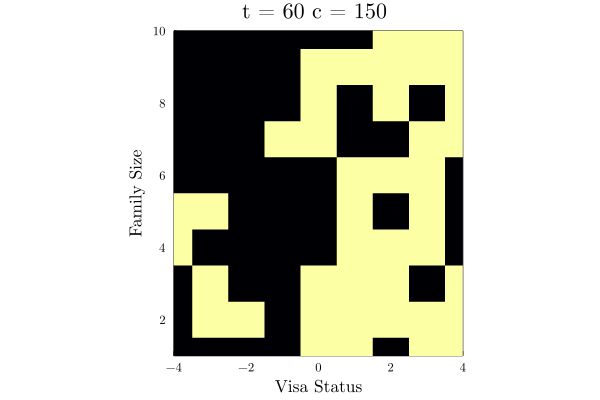

In [75]:
# full time and capacity 
p_1 = vis_time_step(policy, 150, 60)


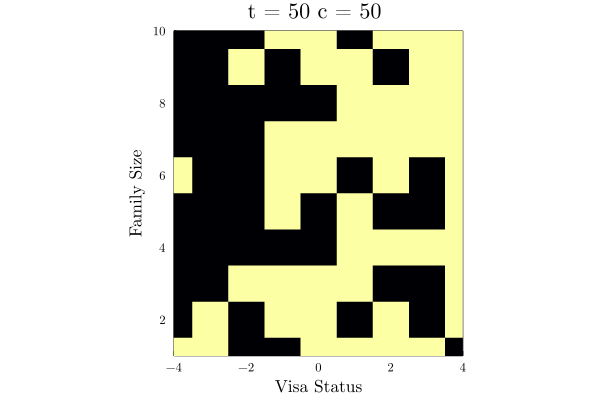

In [76]:
# mid time mid capacity 
p_2 = vis_time_step(policy, 50, 50)


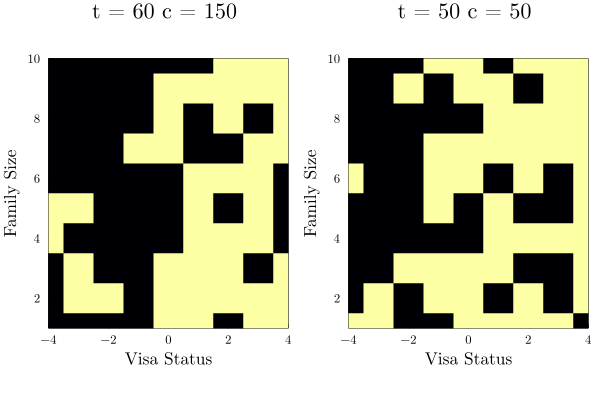

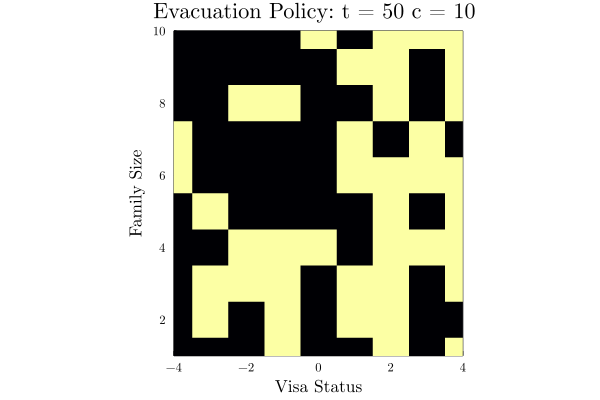

In [65]:
# low time mid capacity
p = vis_time_step(policy, 10, 50)


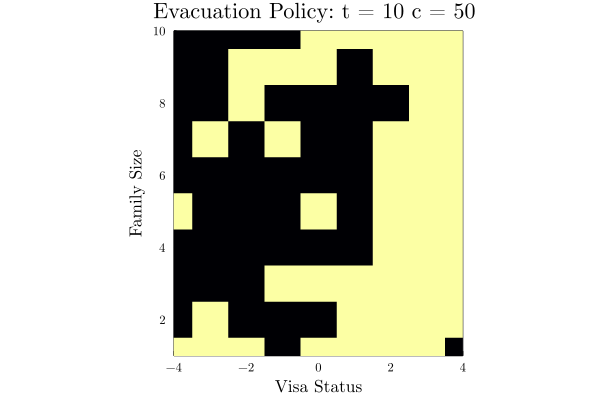

In [66]:
# low capacity high time
p = vis_time_step(policy, 50, 10)


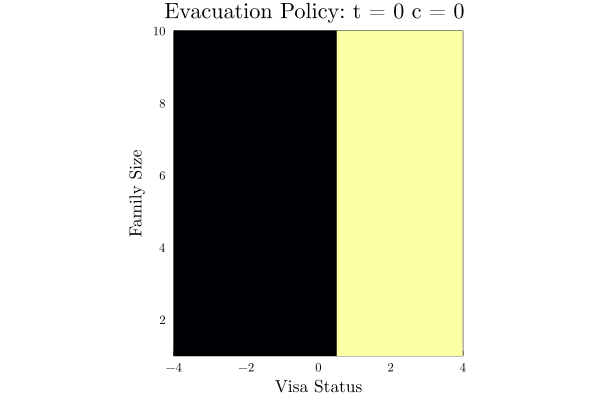

In [60]:
# no time or capacity 
p = vis_time_step(policy, 0, 0)


In [45]:
t = 2
"Evacuation Policy when t = $t"

"Evacuation Policy when t = 2"

In [126]:
# group plot 
# http://docs.juliaplots.org/latest/layouts/
function vis_all(policy)
    total_time = params.time 
    total_capacity = params.capacity
    total_graphs = total_time*total_capacity
    heat_maps = []
    for t in 1:2 #total_time
        for c in 1:2 #total_capacity
            push!(heat_maps, vis_time_step(policy, c, t))
          #  plot(vis_time_step(policy, 1, 1), layout =1)
        end
    end
    return heat_maps
    
   # plot(vis_time_step(policy, 1, 1), layout =1)
   # plot(vis_time_step(policy, c, t), layout =4)
 #   "$heat_maps[i]," for i in 1:2
        
   
  #  plot(heat_maps[i] for i in 1:total_graphs, layout=4)
    # return vis_time_step(policy, c, t)
end



#plot(p_1, p_2, layout = 2)


vis_all (generic function with 1 method)

In [127]:
heat_maps = vis_all(policy)

4-element Vector{Any}:
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}

In [130]:
plot("$heat_maps[i]," for i in 1:2, layout=2)

LoadError: Cannot convert Base.Generator{Base.Iterators.ProductIterator{Tuple{UnitRange{Int64}, Int64}}, var"#14#15"} to series data for plotting

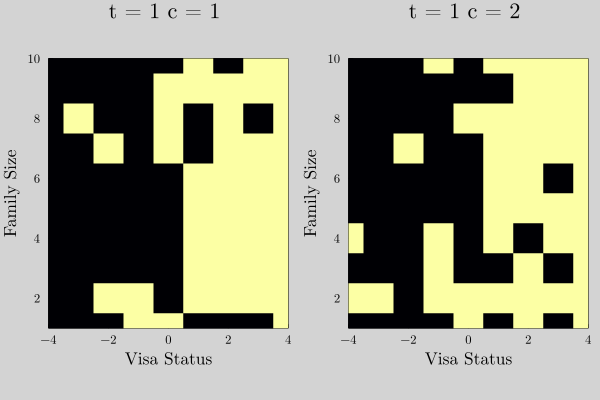

In [118]:
vis_all(policy)

In [111]:
rand(10, 4)

10×4 Matrix{Float64}:
 0.102214  0.31235   0.571898   0.978953
 0.916258  0.974182  0.108625   0.686805
 0.048493  0.851974  0.141568   0.340677
 0.612984  0.202522  0.638267   0.0177051
 0.898834  0.413837  0.0180775  0.630437
 0.775874  0.854111  0.864853   0.43931
 0.839626  0.100376  0.242882   0.195278
 0.413482  0.85789   0.967495   0.513159
 0.445409  0.218646  0.728541   0.0942105
 0.431256  0.581773  0.931416   0.611416

In [113]:
gr(leg = false, bg = :lightgrey)

Plots.GRBackend()

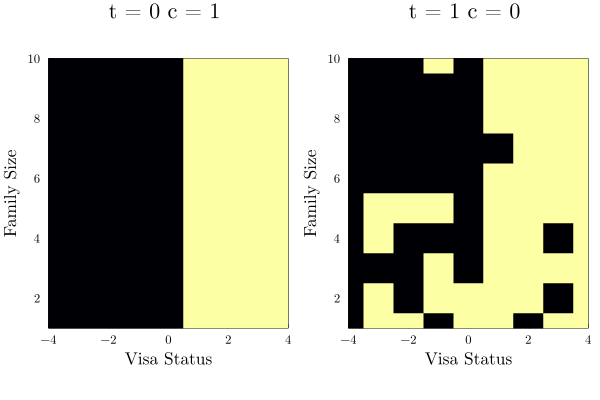

In [114]:
plot(p1, p2)

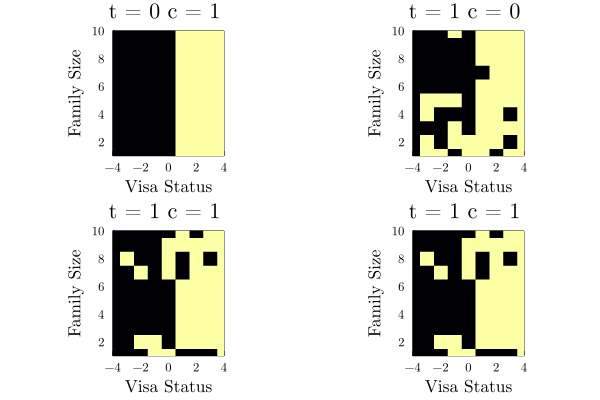

In [107]:
l = @layout [a b;  c d]
p1 = plot(vis_time_step(policy, 1, 0))
p2 = plot(vis_time_step(policy, 0, 1))
p3 = plot(vis_time_step(policy, 1, 1))
p4 = plot(vis_time_step(policy, 1, 1))
plot(p1, p2, p3, p4, layout = l)

In [109]:
vis_all(policy)

In [92]:
l = @layout [
    a{0.2w} [grid(2,2)
             b{0.2h}  ]
]

1×2 Matrix{Any}:
 (label = :a, width = 0.2, height = :auto)  …  Any[Plots.GridLayout(2, 2); (label = :b, width = :auto, height = 0.2)]

In [84]:
vis_all(policy)

LoadError: Cannot convert Base.Generator{Base.Iterators.ProductIterator{Tuple{UnitRange{Int64}, Int64}}, var"#12#13"{Vector{Any}}} to series data for plotting

In [48]:
#@show size(heat_maps) [shouldn't this be 60*20 here]

In [49]:
p = vis(policy, 20, 20)
# plot(p)
#policyGraph = zeros(5,3) #turns into 5 by 3 matrix
#(xmax, ymax) = params.size    


LoadError: UndefVarError: vis not defined

In [50]:
p = vis(policy, 20, 60)
#State(c, t, f, v)

LoadError: UndefVarError: vis not defined

In [51]:
p = vis(policy, 10, 10)


LoadError: UndefVarError: vis not defined

**Simulation**

In [143]:
# one can use the Rollout Simulator 
# from the POMDPSimulators package to find the accumulated discounted reward from a single simulated trajectory as follows:

function simulation(policy, mdp)
    sim = RolloutSimulator()
    r = simulate(sim, mdp, policy) #accumulated discounted reward 
    return r
end



simulation (generic function with 1 method)

In [144]:
simulation(policy, mdp) # this should be changing becuase our MDP has uncertainty??

60.10229454717424